# Лаборатораня работа №2: Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

In [1]:
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('credit_train.csv', encoding='cp1251', sep=';')

In [3]:
# смотрим на первые пять строк
data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


## 1) Обработка пропусков в данных

In [4]:
#проверяем типы данных и заполненность столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  object 
 2   age                   170743 non-null  float64
 3   marital_status        170743 non-null  object 
 4   job_position          170746 non-null  object 
 5   credit_sum            170744 non-null  object 
 6   credit_month          170746 non-null  int64  
 7   tariff_id             170746 non-null  float64
 8   score_shk             170739 non-null  object 
 9   education             170741 non-null  object 
 10  living_region         170554 non-null  object 
 11  monthly_income        170741 non-null  float64
 12  credit_count          161516 non-null  float64
 13  overdue_credit_count  161516 non-null  float64
 14  open_account_flg      170746 non-null  int64  
dtype

In [5]:
#удаляем столбец с номером клиента (так как он незначимый) 
# и с регионом проживания (так как он нуждается в серьезной предобработке)
data.drop(['client_id', 'living_region'], axis=1, inplace=True)

In [6]:
# анализируем столбец marital_status, смотрим, какое значение в нем является самым частым 
data['marital_status'].describe()

count     170743
unique         5
top          MAR
freq       93954
Name: marital_status, dtype: object

In [7]:
# анализируем столбец education, смотрим, какое в нем самое частое значение
data['education'].describe()

count     170741
unique         5
top          SCH
freq       87537
Name: education, dtype: object

In [8]:
# дозаполняем нечисловые столбцы с пропусками самыми часто встречающимися значениями
data['marital_status'].fillna('MAR', inplace=True)
data['education'].fillna('SCH', inplace=True)

In [9]:
# дозаполняем числовые столбцы с пропусками медианными значениями
data['age'].fillna(data['age'].median(), inplace=True)
data['credit_count'].fillna(data['credit_count'].median(), inplace=True)
data['overdue_credit_count'].fillna(data['overdue_credit_count'].median(), inplace=True)

In [10]:
#меняем в столбцах 'credit_sum', 'score_shk'  запятые на точки  и преобразуем их в числовой  формат
for i in ['credit_sum', 'score_shk']:
    data[i] = data[i].str.replace(',', '.').astype('float')

In [11]:
# дозаполняем ставшие теперь числовыми столбцы 'credit_sum', 'score_shk'   медианными значениями
data['score_shk'].fillna(data['score_shk'].median(), inplace=True)
data['monthly_income'].fillna(data['monthly_income'].median(), inplace=True)
data['credit_sum'].fillna(data['credit_sum'].median(), inplace=True)

In [12]:
# смотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170746 non-null  float64
 2   marital_status        170746 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170746 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170746 non-null  float64
 8   education             170746 non-null  object 
 9   monthly_income        170746 non-null  float64
 10  credit_count          170746 non-null  float64
 11  overdue_credit_count  170746 non-null  float64
 12  open_account_flg      170746 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 16.9+ MB


## 2) Кодирование категориальных признаков

In [13]:
category_cols = ['gender', 'job_position', 'education', 'marital_status']

In [14]:
print("Количество уникальных значений\n")
for col in category_cols:
    print(f'{col}: {data[col].unique().size}')

Количество уникальных значений

gender: 2
job_position: 18
education: 5
marital_status: 5


In [15]:
# кодируем нечисловые столбцы методом дамми-кодирования
data = pd.concat([data, 
                      pd.get_dummies(data['gender'], prefix="gender"),
                      pd.get_dummies(data['job_position'], prefix="job_position"),
                      pd.get_dummies(data['education'], prefix="education"),
                      pd.get_dummies(data['marital_status'], prefix="marital_status")],
                     axis=1)

In [16]:
#удаляем старые нечисловые столбцы, вместо них уже появились новые числовые
data.drop(['gender','job_position','education','marital_status'], axis=1, inplace=True)

In [17]:
data.head()

,age,credit_sum,credit_month,tariff_id,score_shk,monthly_income,credit_count,overdue_credit_count,open_account_flg,gender_F,...,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID
0,34.0,59998.00,10,1.6,0.461599,30000.0,1.0,1.0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,34.0,10889.00,6,1.1,0.461599,35000.0,2.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,32.0,10728.00,12,1.1,0.461599,35000.0,5.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,27.0,12009.09,12,1.1,0.461599,35000.0,2.0,0.0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,45.0,21229.00,10,1.1,0.421385,35000.0,1.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0


## 3) Масштабирование данных

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [19]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['credit_sum']])

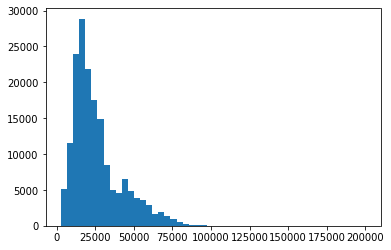

In [28]:
plt.hist(data['credit_sum'], 50)
plt.show()

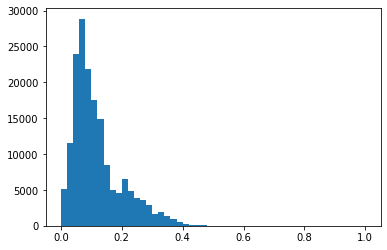

In [22]:
plt.hist(sc1_data, 50)
plt.show()

In [23]:
scCredMon = MinMaxScaler()
scCredMon = scCredMon.fit_transform(data[['credit_month']])

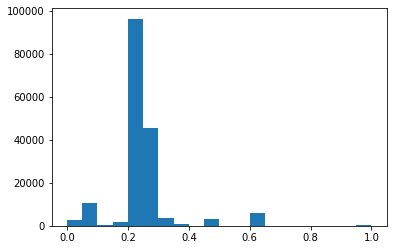

In [29]:
plt.hist(scCredMon, 20)
plt.show()

In [30]:
scMonInc = MinMaxScaler().fit_transform(data['monthly_income'].values.reshape(-1, 1))

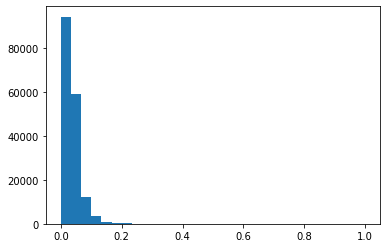

In [33]:
plt.hist(scMonInc, 30)
plt.show()